<div style="clear: both">
    <h2 style="float: left">IBM Data Science Professional Certificate</h2>
    <h3 style="float: right">Applied Data Science Captone</h3>
</div>

<h1 align="center"><font size="+3">Exploring Riyadh Neighborhoods</font></h1>

## Table of contents
1. [Introduction](#introduction)
2. [Methodologie ](#methodologie)
3. [Data Collection](#data_collection)
4. [Data Cleaning](#data_cleaning)
5. [Data Preparation](#data_preparation)
6. [Data Prerocessing](#data_preprocessing)
7. [Neighborhoods Clustering](#clustering)
8. [Clustering Results](#results)

## 1. Introduction <a name='introduction'></a>
### 1.1 Background
During this last course of the professional certificate, we've been using different tools to explore famous cities like **New York & Toronto**. The process was simple: gather data about the city, use **Foursquare API** to explore the venues in the neighborhoods and then group similar neighborhoods into different clusters.

In order to accomplish the final assignment, I've decided to explore also one of the popular cities in the world : ***Riyadh City***.
### 1.2 About Riyadh City
***Riyadh*** ('The Gardens') is the capital and main financial hub of *Saudi Arabia*, and the largest city on the Arabian Peninsula. Located in the center of the an-Nafud desert, on the eastern part of the Najd plateau, the city sits at an average of 600 meters (2,000 ft) above sea level, and receives around **5 million tourists** each year, making it **the forty-ninth most visited city in the world** and **the 6th in the Middle East**. 
Riyadh had a population of 7.6 million people in 2019, making it the most-populous city in Saudi Arabia, 3rd most populous in the Middle East, and 38th most populous in Asia.

### 1.3 Objective
The main goal of this project is to explore the city and answer the following questions :
* What are the most common venues in the city?
* Which neighborhoods in the city are similar?

The answers to these questions could be exploited by :
* Tourists that would like to come and explore the city.
* People moving to the city for a job offer, or looking for a better neighborhood to live in.
* Small investors who would like to open a restaurant, a market etc.

## 2. Methodologie <a name='methodologie'></a>
* Collect main information about neighborhoods : ***Postal code, Municipality and Neighborhood's name***. 
* Translate data from Arabic to English and ensure that no null or duplicate values are present in the dataset.
* Collect the geo-coordinations of each neighborhood.
* Using the geo-coordinations and the *Foursquare API*, Gather the top 100 venues in each neighborhood within a radius of 500 meters.
* Exctract the top 10 venues in each neighborhood.
* Cluster neighborhoods based on their similarities.

### Import libraries

In [1]:
import pandas as pd
import numpy as np

from selenium import webdriver
import requests

from bs4 import BeautifulSoup

from deep_translator import GoogleTranslator

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import folium
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

## 3. Data Collection <a name='data_collection'></a>
The data we need about Riyadh City is in the following [link](https://www.almrsal.com/post/980209). This page contains informations about each **municipality** in the city, their corresponding **neighborhoods** and **postal codes**.

These informations are required for the rest of the work, but they are in arabic, so we'll extract them and then translate the collected data.
### 3.1 Web scrapping
To retrieve the results from the mentioned web site, we'll be using a library called **Selenium** and its feature **webdriver**. To extract the data from the page, we'll parse the HTML using **BeautifulSoup**

In [2]:
# assign the url
url = 'https://www.almrsal.com/post/980209'
# scrap the url

# Selenium requires a driver to interface with the chosen browser.
# for Chrome download the driver from : https://sites.google.com/a/chromium.org/chromedriver/downloads
d = webdriver.Chrome('C:/Users/Hichem/Downloads/compressed/chromedriver') # pass the driver location
d.get('https://www.almrsal.com/post/980209') # send the GET request
results = d.page_source # Retrieve the results

### 3.2 Examine the results

'<html dir="rtl" lang="ar" prefix="og: http://ogp.me/ns#">\n <head>\n  <meta charset="utf-8"/>\n  <link href="//gmpg.org/xfn/11" rel="profile"/>\n  <link href="//www.almrsal.com/xmlrpc.php" rel="pingback"/>\n  <style media="all">\n   :root{--wp-admin-theme-color:#007cba;--wp-admin-theme-color-darker-10:#006ba1;--wp-admin-theme-color-darker-20:#005a87}#start-resizable-editor-section{display:none}.wp-block-audio figcaption{margin-top:.5em;margin-bottom:1em}.wp-block-audio audio{width:100%;min-width:300px}.wp-block-button__link{color:#fff;background-color:#32373c;border:none;border-radius:1.55em;box-shadow:none;cursor:pointer;display:inline-block;font-size:1.125em;padding:.667em 1.333em;text-align:center;text-decoration:none;overflow-wrap:break-word}.wp-block-button__link:active,.wp-block-button__link:focus,.wp-block-button__link:hover,.wp-block-button__link:visited{color:#fff}.wp-block-button__link.aligncenter{text-align:center}.wp-block-button__link.alignright{text-align:right}.wp-block
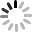
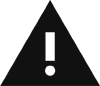
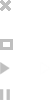
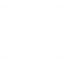
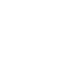
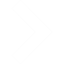
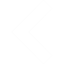
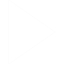
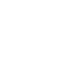
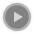
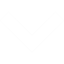
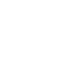
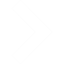
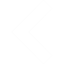

In [3]:
# parse the html results
soup = BeautifulSoup(results, 'html.parser')
soup.prettify()

After examining the web page and the HTML results :
* The municipalities' names are in header 3 format.
* There's 101 element in header 3 format, but fortunaly the names are the first 16 tags.
* There's 16 table that contains the neighborhoods' names and thier postal codes.

Extracting the municipalities names :

In [4]:
# get the first 16 elements of the header 3 tags
muns = soup.find_all('h3')[:16]
# extract the names
muns_ar = []
for mun in muns :
    muns_ar.append(mun.getText().strip())
muns_ar

['بلدية العليا',
 'بلدية البطحاء',
 'بلدية الحائر',
 'بلدية الدرعية',
 'بلدية الروضة',
 'بلدية السلي',
 'بلدية الشفا',
 'بلدية الشميسي',
 'بلدية العريجاء',
 'بلدية العزيزية',
 'بلدية المعذر',
 'بلدية الملز',
 'بلدية النسيم',
 'بلدية شمال الرياض',
 'بلدية عرقة',
 'بلدية نمار']

Extract the neighborhoods, the postal codes :

In [5]:
tables = soup.find_all('table') # get all the tables
# for each table get the neighborhood's name, the postal code and store them with their corresponding municipality
results = []
for i in range(len(tables)) :
    mun = muns_ar[i] # municipality name
    table = tables[i] # get the table
    rows = table.find_all('tr') # get the table's rows
    rows.pop(0) # drop the first row because it contains the headers
    
    # iterate through each row elements
    for row in rows :
        # extract each row elements        
        contents = row.find_all('td')
        neighborhood = contents[0].getText().strip()
        postal_code = contents[1].getText().strip()
        
        # store the results
        results.append((mun, neighborhood, postal_code))

print("There's {} municipality in Riyadh city with a total of {} neighborhood".format(len(muns_ar), len(results)))

There's 16 municipality in Riyadh city with a total of 203 neighborhood


### 3.3 Load the data
Transform the data into a pandas dataframe :

In [6]:
riyadh_df = pd.DataFrame(results, columns=['Municipality_ar', 'Neighborhood_ar', 'Postal_code'])
riyadh_df.head()

,Municipality_ar,Neighborhood_ar,Postal_code
0,بلدية العليا,حي العليا,12222
1,بلدية العليا,حي الازدهار,12486
2,بلدية العليا,حي المصيف,12466
3,بلدية العليا,حي التعاون,12475
4,بلدية العليا,حي الورود,12252


### 3.4 Data transformation
Now let's translate all those names from arabic to english. To do that we'll use the `deep-translator` module, it's one of the modules that makes it straightforward to translate texts, and it provides support for multiple famous translators.

> `Deep_translator` is a flexible python package to translate between different languages in a simple way. Basically, the goal of the package is to integrate many translators including `Google Translator`, `DeepL`, `Pons`, `Linguee` and others in one extensive tool.

First let's translate the municipalities' names. The unique names are listed in the **muns_ar** list :

In [7]:
# create the translator instance
translator = GoogleTranslator(source='ar', target='en')
# translate the list muns_ar and store the results in the list muns_en
muns_en = [translator.translate(mun) for mun in muns_ar]
muns_en

['Olaya municipality',
 'Al-Batha Municipality',
 "Al-Ha'ir Municipality",
 'Diriyah Municipality',
 'Al-Rawda Municipality',
 'Al-Selay Municipality',
 'Al Shifa Municipality',
 'Al-Shumaisi Municipality',
 'Al-Uraija Municipality',
 'Azizia Municipality',
 'Al Maather Municipality',
 'Malaz Municipality',
 'Al Naseem Municipality',
 'North Riyadh Municipality',
 'Irqah Municipality',
 'Nammar Municipality']

Let's now remove the word *municipality* :

In [8]:
muns_en = [mun[:-len(' municipality')] for mun in muns_en]
muns_en

['Olaya',
 'Al-Batha',
 "Al-Ha'ir",
 'Diriyah',
 'Al-Rawda',
 'Al-Selay',
 'Al Shifa',
 'Al-Shumaisi',
 'Al-Uraija',
 'Azizia',
 'Al Maather',
 'Malaz',
 'Al Naseem',
 'North Riyadh',
 'Irqah',
 'Nammar']

Now we'll populate our dataframe with the new inputs :

In [9]:
for mun_ar, mun_en in zip(muns_ar, muns_en) :
    indicies = riyadh_df[riyadh_df['Municipality_ar'] == mun_ar].index
    for index in indicies :
        riyadh_df.loc[index, 'Municipality_en'] = mun_en
        
riyadh_df.head()

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en
0,بلدية العليا,حي العليا,12222,Olaya
1,بلدية العليا,حي الازدهار,12486,Olaya
2,بلدية العليا,حي المصيف,12466,Olaya
3,بلدية العليا,حي التعاون,12475,Olaya
4,بلدية العليا,حي الورود,12252,Olaya


Great, now let's also populate the dataframe with the neighborhoods' names in english :

In [10]:
# create the translator instance
translator = GoogleTranslator(source='ar', target='en')
# translate the neighborhood name and assign it to to the dataframe
riyadh_df['Neighborhood_en'] = riyadh_df['Neighborhood_ar'].apply(lambda x : translator.translate(x))
riyadh_df.head(10)

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en,Neighborhood_en
0,بلدية العليا,حي العليا,12222,Olaya,Al Alia District
1,بلدية العليا,حي الازدهار,12486,Olaya,Al-Izdihar District
2,بلدية العليا,حي المصيف,12466,Olaya,Al-Masif District
3,بلدية العليا,حي التعاون,12475,Olaya,In terms of cooperation
4,بلدية العليا,حي الورود,12252,Olaya,Al-Worood District
5,بلدية العليا,حي الملك فهد,12271,Olaya,King Fahd District
6,بلدية العليا,حي المروج,12284,Olaya,Promoter neighborhood
7,بلدية العليا,حي المغرزات,12482,Olaya,Al-Mughrizat district
8,بلدية العليا,حي المرسلات,12461,Olaya,Al-Morsalat District
9,بلدية العليا,حي النزهة,12471,Olaya,Al-Nuzha District


Let's remove the words *district* and *neighborhood*, and also correct some names :

In [11]:
# remove the word district
riyadh_df['Neighborhood_en'] = riyadh_df['Neighborhood_en'].str.replace(' District', '', case=False)
# remove the word neighborhood
riyadh_df['Neighborhood_en'] = riyadh_df['Neighborhood_en'].str.replace(' neighborhood', '', case=False)
# correct some names
riyadh_df.loc[3, 'Neighborhood_en'] = 'Al-Taawon'
riyadh_df.loc[6, 'Neighborhood_en'] = 'Al-Mourouj'

riyadh_df.head(10)

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en,Neighborhood_en
0,بلدية العليا,حي العليا,12222,Olaya,Al Alia
1,بلدية العليا,حي الازدهار,12486,Olaya,Al-Izdihar
2,بلدية العليا,حي المصيف,12466,Olaya,Al-Masif
3,بلدية العليا,حي التعاون,12475,Olaya,Al-Taawon
4,بلدية العليا,حي الورود,12252,Olaya,Al-Worood
5,بلدية العليا,حي الملك فهد,12271,Olaya,King Fahd
6,بلدية العليا,حي المروج,12284,Olaya,Al-Mourouj
7,بلدية العليا,حي المغرزات,12482,Olaya,Al-Mughrizat
8,بلدية العليا,حي المرسلات,12461,Olaya,Al-Morsalat
9,بلدية العليا,حي النزهة,12471,Olaya,Al-Nuzha


Now our dataframe is ready to be inspected !

### 3.5 Inspect the data

In [12]:
riyadh_df.shape

(203, 5)

There is a total of 203 neigborhoods in Riyadh City. Let's check for nulls :

In [13]:
riyadh_df.isnull().mean()

Municipality_ar    0.0
Neighborhood_ar    0.0
Postal_code        0.0
Municipality_en    0.0
Neighborhood_en    0.0
dtype: float64

Since our data set doesn't contain any null values let's see if it contains any duplicates..

In [14]:
riyadh_df.duplicated().mean()

0.0

In general terms there's no duplicates in our dataframe. Let's go further and see if there exists the same neighborhood with the same postal code in different municipalities.

In [15]:
riyadh_df.duplicated(['Postal_code', 'Neighborhood_en']).mean()

0.009852216748768473

In [16]:
riyadh_df[riyadh_df.duplicated(['Postal_code', 'Neighborhood_en'], keep=False)]

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en,Neighborhood_en
41,بلدية الحائر,حي المنصورية,14531,Al-Ha'ir,Mansouriya
114,بلدية الشميسي,حي المعذر,12721,Al-Shumaisi,Al-Maather
134,بلدية العزيزية,حي المنصورية,14531,Azizia,Mansouriya
135,بلدية المعذر,حي المعذر,12721,Al Maather,Al-Maather


Two neighborhoods appeared within two different municipalities. After a little research, i found out that in *Riyadh* a neighborhood could be shared by different municipalities.

Now let's check if there exists different neighborhoods with same postal code :

In [17]:
riyadh_df['Postal_code'].duplicated().mean()

0.08866995073891626

In [18]:
indicies = riyadh_df[riyadh_df.duplicated(['Postal_code', 'Neighborhood_en'], keep=False)].index # to eleminate the previous results
riyadh_df[riyadh_df['Postal_code'].duplicated(keep=False)].drop(index=indicies).sort_values(by=['Postal_code'])

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en,Neighborhood_en
194,بلدية عرقة,حي الخزامى,12514,Irqah,Al-Khuzama
190,بلدية عرقة,حي السفارات,12514,Irqah,Al Sefarat
154,بلدية الملز,حي المربع,12624,Malaz,Al-Murabba
151,بلدية الملز,حي الوزارات,12624,Malaz,Ministries
27,بلدية البطحاء,حي المرقب,12645,Al-Batha,Al Marqab
148,بلدية الملز,حي ثليم,12645,Malaz,Thelem
23,بلدية البطحاء,حي سلام,12651,Al-Batha,Peace
30,بلدية البطحاء,حي الدوبية,12651,Al-Batha,Al-Doubieh
18,بلدية البطحاء,حي الوسيطاء,12652,Al-Batha,Al-Waseet
24,بلدية البطحاء,حي جبرة,12652,Al-Batha,Jabra


After observing the above table :
* Some neighborhoods share the same postal code and they belong to the same municipality.
* Some neighborhoods share the same postal code but they belong to different municipalities.
* After referring to the arabic names, i found out that for the postal code number 14522, the neighborhood with the index 73 have the correct neighborhood name (two merged names).

## 4. Data Cleaning<a name='data_cleaning'></a>
To deal with the duplicates we'll follow these steps :
* For neighborhoods that are shared by two different municipalities, we'll merge the municipalities names.
* Neighborhoods with the same postal codes and the same municipality will be merged together.
* If a postal code have different neighborhoods and different municipalities, we'll keep one item of that postal code with merged names.
* For the exception (postal code number 14522), we'll keep the first item (index number 73) because it has the right neighborhood name and we shoul add the name of the second municipality (row number 132) before droping it.

In [19]:
# list of duplicated postal codes
dup_pc = riyadh_df[riyadh_df['Postal_code'].duplicated()]['Postal_code'].unique()

to_drop = [] # list of rows to drop
for pc in dup_pc :
    # get the elements of each column
    temp_df = riyadh_df[riyadh_df['Postal_code'] == pc]
    
    mun_ar = temp_df['Municipality_ar']
    mun_en = temp_df['Municipality_en']
    neigh_ar = temp_df['Neighborhood_ar']
    neigh_en = temp_df['Neighborhood_en']
    
    indicies = list(temp_df.index.values)
    
    # correct the exception and neighborhood in two different municipalities
    if pc == '14522' or (len(neigh_en) != len(set(neigh_en)))  :
        # merge the municipalities names
        new_mun_ar = ' - '.join(mun_ar)
        new_mun_en = ' - '.join(mun_en)
        # assign the new names to the first element
        riyadh_df.loc[indicies[0], 'Municipality_ar'] = new_mun_ar
        riyadh_df.loc[indicies[0], 'Municipality_en'] = new_mun_en
        # store the rows to drop indicies
        to_drop += indicies[1:]
        
    # process neighborhoods with the same postal code and same municipality
    elif len(mun_en) != len(set(mun_en)) :
        # merge the neighborhoods names
        new_neigh_ar = ' - '.join(neigh_ar)
        new_neigh_en = ' - '.join(neigh_en)
        # assign the new names to the first element
        riyadh_df.loc[indicies[0], 'Neighborhood_ar'] = new_neigh_ar
        riyadh_df.loc[indicies[0], 'Neighborhood_en'] = new_neigh_en
        # store the rows to drop indicies
        to_drop += indicies[1:]
        
    # process neighborhoods with the same postal code and different municipalities
    else :
        # merge the neighborhoods and municipalities names
        new_mun_ar = ' - '.join(mun_ar)
        new_mun_en = ' - '.join(mun_en)
        new_neigh_ar = ' - '.join(neigh_ar)
        new_neigh_en = ' - '.join(neigh_en)
        # assign the new names to the first element
        riyadh_df.loc[indicies[0], 'Municipality_ar'] = new_mun_ar
        riyadh_df.loc[indicies[0], 'Municipality_en'] = new_mun_en
        riyadh_df.loc[indicies[0], 'Neighborhood_ar'] = new_neigh_ar
        riyadh_df.loc[indicies[0], 'Neighborhood_en'] = new_neigh_en
        # store the rows to drop indicies
        to_drop += indicies[1:]
        
riyadh_df = riyadh_df.drop(index=to_drop).reset_index(drop=True)
riyadh_df.head(10)

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en,Neighborhood_en
0,بلدية العليا,حي العليا,12222,Olaya,Al Alia
1,بلدية العليا,حي الازدهار,12486,Olaya,Al-Izdihar
2,بلدية العليا,حي المصيف,12466,Olaya,Al-Masif
3,بلدية العليا,حي التعاون,12475,Olaya,Al-Taawon
4,بلدية العليا,حي الورود,12252,Olaya,Al-Worood
5,بلدية العليا,حي الملك فهد,12271,Olaya,King Fahd
6,بلدية العليا,حي المروج,12284,Olaya,Al-Mourouj
7,بلدية العليا,حي المغرزات,12482,Olaya,Al-Mughrizat
8,بلدية العليا,حي المرسلات,12461,Olaya,Al-Morsalat
9,بلدية العليا,حي النزهة,12471,Olaya,Al-Nuzha


Confirm changes :

In [20]:
riyadh_df.shape

(185, 5)

In [21]:
riyadh_df[riyadh_df['Postal_code'].isin(dup_pc)]

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en,Neighborhood_en
18,بلدية البطحاء,حي الوسيطاء - حي جبرة - حي البطيحا - حي القرى ...,12652,Al-Batha,Al-Waseet - Jabra - Al-Bateha - The villages -...
23,بلدية البطحاء,حي سلام - حي الدوبية,12651,Al-Batha,Peace - Al-Doubieh
25,بلدية البطحاء - بلدية الملز,حي المرقب - حي ثليم,12645,Al-Batha - Malaz,Al Marqab - Thelem
36,بلدية الحائر - بلدية العزيزية,حي المنصورية,14531,Al-Ha'ir - Azizia,Mansouriya
39,بلدية الدرعية,حي الملك - حي الفيصلية - حي الروقية,13712,Diriyah,The King's - Al Faisaliah - Al Rouqia
46,بلدية الدرعية,حي البليدا - حي العلب,13732,Diriyah,Al-Balida - Al-Alab
65,بلدية الروضة - بلدية العزيزية,حي الرحاب – طيبة,14522,Al-Rawda - Azizia,Al-Rehab - Taiba
106,بلدية الشميسي - بلدية المعذر,حي المعذر,12721,Al-Shumaisi - Al Maather,Al-Maather
112,بلدية العريجاء - بلدية نمار,حي العريجاء – حي العريجاء الوسطى - حي لبن,12765,Al-Uraija - Nammar,Al-Uraija - Al-Uraija Al-Wusta - Labn
115,بلدية العريجاء,حي ظهرة البديعة - حي السويدي,12788,Al-Uraija,Dhahrat Al Badi'ah - As-Suwaidi


In [22]:
riyadh_df['Postal_code'].duplicated().mean()

0.0

## 5. Data preparation<a name='data_preparation'></a>
To be ready for exploring our city, we need to get the latitude and the longitude for each one of the neighborhoods. To do that i'll use [Geocoder API](https://developer.here.com/documentation/geocoding-search-api/dev_guide/topics/endpoint-geocode-brief.html). This API finds you the geo-coordinates of a known address, place, locality or administrative area, even if the query is incomplete or partly incorrect.

In [23]:
URL = "https://geocode.search.hereapi.com/v1/geocode" # API url
api_key = 'GBm_o7zG7vF5G61N0A_wPM34pzH10**************' # acquired from developer.here.com

coordinates = {'Lattitude': [], 'Longitude': []} # store the results

# use the postal code to find the geo-coordinates
for postal_code in riyadh_df['Postal_code'] :
    address = '{}, Riyadh'.format(postal_code)
    PARAMS = {'apikey':api_key,'q':address}
    r = requests.get(url = URL, params = PARAMS) 
    data = r.json()
    try :
        lat, lng = data['items'][0]['position']['lat'], data['items'][0]['position']['lng']    
    except :
        lat, lng = None, None
    coordinates['Lattitude'] = coordinates.get('Lattitude') + [lat]
    coordinates['Longitude'] = coordinates.get('Longitude') + [lng]

riyadh_df[['Latitude', 'Longitude']] = pd.DataFrame(coordinates)
riyadh_df.head()

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en,Neighborhood_en,Latitude,Longitude
0,بلدية العليا,حي العليا,12222,Olaya,Al Alia,24.69502,46.69004
1,بلدية العليا,حي الازدهار,12486,Olaya,Al-Izdihar,24.77904,46.72446
2,بلدية العليا,حي المصيف,12466,Olaya,Al-Masif,24.76386,46.68849
3,بلدية العليا,حي التعاون,12475,Olaya,Al-Taawon,24.76724,46.69640
4,بلدية العليا,حي الورود,12252,Olaya,Al-Worood,24.72213,46.68584


In [24]:
riyadh_df.isnull().mean()

Municipality_ar    0.0
Neighborhood_ar    0.0
Postal_code        0.0
Municipality_en    0.0
Neighborhood_en    0.0
Latitude           0.0
Longitude          0.0
dtype: float64

Every neighborhood has its latitude and longitude values, and our dataframe is ready for the next step

## 6. Data Preprocessing<a name='data_preprocessing'></a>
### 6.1 Exploring venues in neighborhoods
To accomplish this task we'll use `Foursquare API`. Foursquare is a social location service that allows users to explore the world around them.

First we need our credentials :

In [25]:
CLIENT_ID = 'QPZRG0JP5PLKEYEA24CT3DIU2R1VKLXOM2G4PQVNN3BOTLZK' #Foursquare ID
CLIENT_SECRET = 'CHNHPEPBTKUHBGN3LSQA5SS5PFDCBNY5KM**************' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

The following function explores the venues in a given neighborhood and returns the results in form of a dataframe :

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    tot_neigh = 0
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('Retreiving results for :', name, '...')
        tot_neigh += 1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    print('Number of neighborhoods processed :', tot_neigh)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Exploring neighborhoods :

In [27]:
riyadh_venues = getNearbyVenues(names=riyadh_df['Neighborhood_en'],
                                   latitudes=riyadh_df['Latitude'],
                                   longitudes=riyadh_df['Longitude']
                                  )

Retreiving results for : Al Alia ...
Retreiving results for : Al-Izdihar ...
Retreiving results for : Al-Masif ...
Retreiving results for : Al-Taawon ...
Retreiving results for : Al-Worood ...
Retreiving results for : King Fahd ...
Retreiving results for : Al-Mourouj ...
Retreiving results for : Al-Mughrizat ...
Retreiving results for : Al-Morsalat ...
Retreiving results for : Al-Nuzha ...
Retreiving results for : Saladin ...
Retreiving results for : Sulaymaniyah ...
Retreiving results for : King Abdulaziz ...
Retreiving results for : King Abdullah ...
Retreiving results for : Al-Waha ...
Retreiving results for : Al Faisaliah ...
Retreiving results for : Al-Yamamah ...
Retreiving results for : Ateeqa ...
Retreiving results for : Al-Waseet - Jabra - Al-Bateha - The villages - Maakal ...
Retreiving results for : New Manfouha ...
Retreiving results for : Manfouha ...
Retreiving results for : Al Khaldiyeh ...
Retreiving results for : Ghubaira ...
Retreiving results for : Peace - Al-Doubieh

Check the results :

In [28]:
print('The process gives a total of {} venues in Riyadh City, with {} unique categories for the venues'.format(riyadh_venues.shape[0], len(riyadh_venues['Venue Category'].unique())))
riyadh_venues.head(15)

The process gives a total of 2252 venues in Riyadh City, with 239 unique categories for the venues


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Al Alia,24.69502,46.69004,Paskalia (بسكاليا),24.697674,46.687086,Restaurant
1,Al Alia,24.69502,46.69004,Cacti Cafe,24.698523,46.688123,Coffee Shop
2,Al Alia,24.69502,46.69004,Starbucks (ستاربكس),24.699015,46.689939,Coffee Shop
3,Al Alia,24.69502,46.69004,Tutti Cafè (أنواع القهوة),24.697852,46.687181,Café
4,Al Alia,24.69502,46.69004,Adidas Originals,24.698398,46.687715,Sporting Goods Shop
5,Al Alia,24.69502,46.69004,Tim Hortons (تيم هورتنز),24.698790,46.689771,Coffee Shop
6,Al Alia,24.69502,46.69004,Le Gourmet (الذواق),24.691527,46.691695,Bakery
7,Al Alia,24.69502,46.69004,Zara Man (زارا مان),24.698963,46.691498,Clothing Store
8,Al Alia,24.69502,46.69004,Fitness First Ladies,24.698749,46.691229,Gym / Fitness Center
9,Al Alia,24.69502,46.69004,Labouchee (لابوشيه),24.691923,46.692852,Cupcake Shop


#### Visualizing total numbers of venues in each district

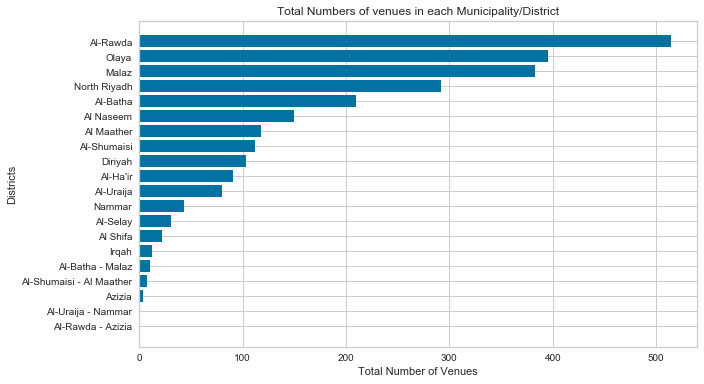

In [29]:
venues = pd.DataFrame(riyadh_venues.groupby('Neighborhood').count()['Venue Category'])

temp_df = riyadh_df.merge(venues, left_on='Neighborhood_en', right_on='Neighborhood')
top_mun = temp_df.groupby('Municipality_en').sum()['Venue Category'].sort_values()

plt.figure(figsize=(10, 6))
plt.barh(top_mun.index, top_mun)
plt.xlabel('Total Number of Venues')
plt.ylabel('Districts')
plt.title('Total Numbers of venues in each Municipality/District')
plt.show()

There's an obvious difference between districts from the above plot. We can divide municipalitie in the city to 3 different categories :
* Popluated disticts with more than 300 venues.
* Medium size municipalites with at least 100 venues.
* Districts with a little number of venues compared to the others.

#### Top 10 neighborhoods with the most number of venues

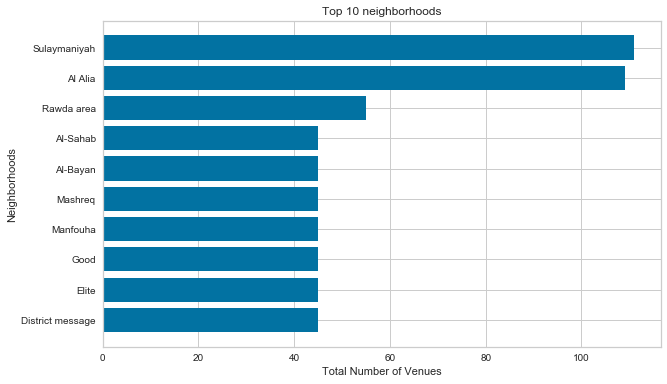

In [30]:
top_neigh = venues.sort_values(by='Venue Category',ascending=True).tail(10)

plt.figure(figsize=(10, 6))
plt.barh(top_neigh.index, top_neigh['Venue Category'])
plt.xlabel('Total Number of Venues')
plt.ylabel('Neighborhoods')
plt.title('Top 10 neighborhoods')
plt.show()

We observe here a huge difference between the neighborhoods, *Al Alia* and *Sulaymaniah* have more than 100 venue each while the rest eight of the top 10 have less than 60 venues.

### 6.2 Extract the top 10 venues for each neighborhood
First step is to get the frequency of each venue category in each neighborhood :

In [31]:
# one hot encoding
neigh_onehot = riyadh_venues[['Neighborhood']].join(pd.get_dummies(riyadh_venues[['Venue Category']], prefix="", prefix_sep=""))

# compute the frequency
neigh_grouped = neigh_onehot.groupby('Neighborhood').mean().reset_index()
neigh_grouped.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport Lounge,Airport Terminal,American Restaurant,Amphitheater,Antique Shop,...,Used Bookstore,Vacation Rental,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Watch Shop,Water Park,Women's Store,Yemeni Restaurant,Yoga Studio
0,Ad-Durahimiyah,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Al Alia,0.0,0.0,0.0,0.0,0.0,0.0,0.009174,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Al Aqiq,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Al Faisaliah,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Al Fakhriyah,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Based on the previous dataframe we'll extract the top 10 venues.
This function returns the top n venues for each neighborhood :

In [32]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [33]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neigh_venues_sorted = pd.DataFrame(columns=columns)
neigh_venues_sorted['Neighborhood'] = neigh_grouped['Neighborhood']

# populate the dataframe with the corresponding values
for ind in np.arange(neigh_grouped.shape[0]):
    neigh_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neigh_grouped.iloc[ind, :], num_top_venues)

neigh_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ad-Durahimiyah,Food Truck,Sandwich Place,Arts & Crafts Store,Yoga Studio,Film Studio,Filipino Restaurant,Fast Food Restaurant,Farm,Falafel Restaurant,Fabric Shop
1,Al Alia,Coffee Shop,Café,Cupcake Shop,Dessert Shop,Sporting Goods Shop,Men's Store,Clothing Store,Donut Shop,Bakery,Ice Cream Shop
2,Al Aqiq,Juice Bar,Mobile Phone Shop,Breakfast Spot,Fast Food Restaurant,Sporting Goods Shop,Burger Joint,Food Truck,Cafeteria,Café,Restaurant
3,Al Faisaliah,Coffee Roaster,Department Store,Furniture / Home Store,Auto Garage,Yoga Studio,Electronics Store,Flea Market,Film Studio,Filipino Restaurant,Fast Food Restaurant
4,Al Fakhriyah,Hookah Bar,Asian Restaurant,Coffee Shop,Pedestrian Plaza,Campground,Sports Bar,Health Food Store,Health & Beauty Service,Fast Food Restaurant,Farm


## 7. Neighborhoods Clustering<a name='clustering'></a>

### 7.1 K-Means clustering
#### Choosing the optimal K value
There is a popular method known as elbow method which is used to determine the optimal value of K to perform the K-Means Clustering Algorithm. The basic idea behind this method is that it plots the various values of cost with changing k. As the value of K increases, there will be fewer elements in the cluster. So average distortion will decrease. The lesser number of elements means closer to the centroid. So, the point where this distortion declines the most is the elbow point.

The easiest way to do this task is with the `ElbowVisualizer` function from **Yellowbrick**.
> The Yellowbrick library is a diagnostic visualization platform for machine learning that allows data scientists to steer the model selection process. It extends the scikit-learn API with a new core object: the `Visualizer`. Visualizers allow models to be fit and transformed as part of the scikit-learn pipeline process, providing visual diagnostics throughout the transformation of high-dimensional data.

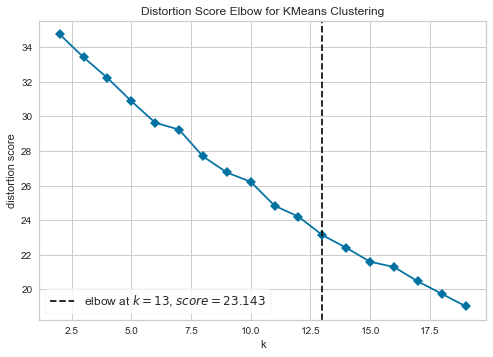

In [34]:
X = neigh_grouped.drop('Neighborhood', 1)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20), timings=False)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

The elbow method has indicated that the optimal k is 13 with a score of 23.143. Dividing our neighborhoods into 13 different groups is not a good choice, so we need another method. Let's use the `SilhouetteVisualizer`.

Silhouette analysis can be used to evaluate the density and separation between clusters. The score is calculated by averaging the silhouette coefficient for each sample, which is computed as the difference between the average intra-cluster distance and the mean nearest-cluster distance for each sample, normalized by the maximum value. This produces a score between -1 and +1, where scores near +1 indicate high separation and scores near -1 indicate that the samples may have been assigned to the wrong cluster.

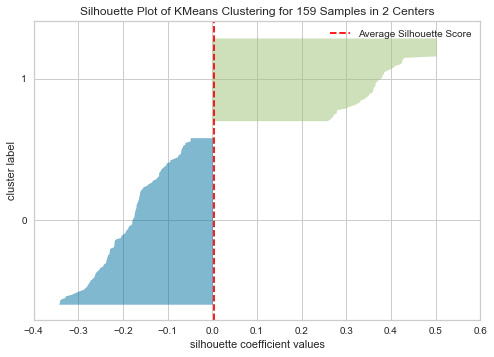

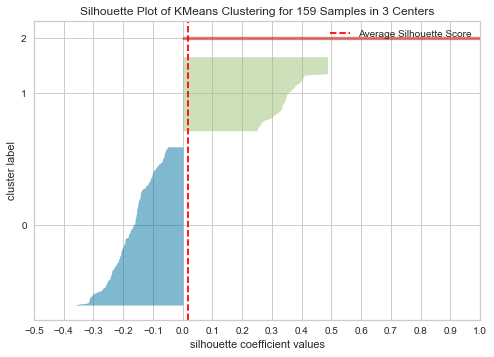

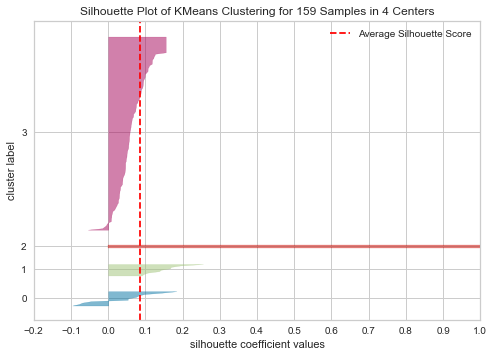

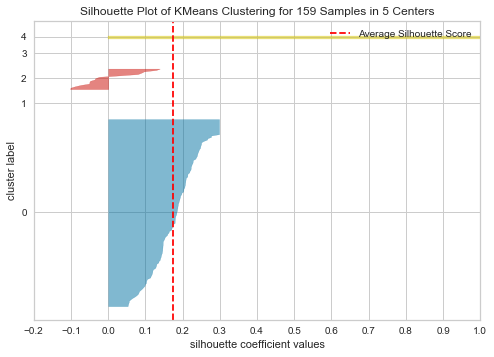

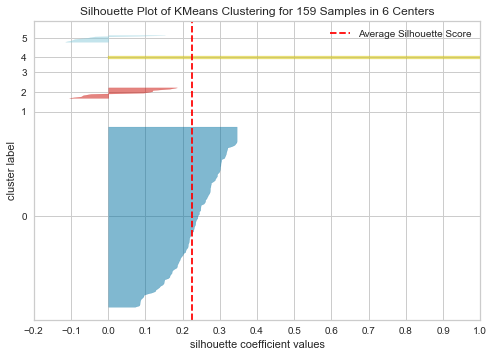

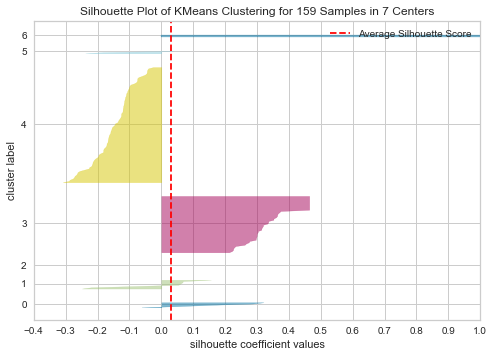

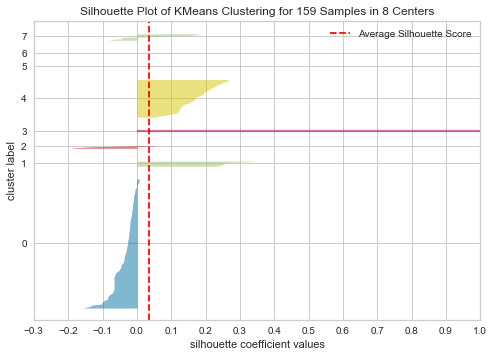

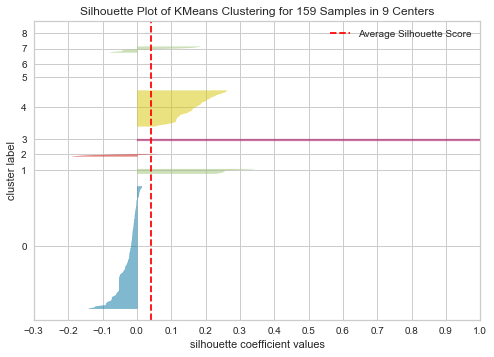

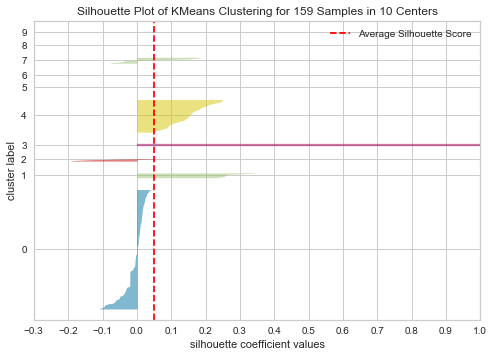

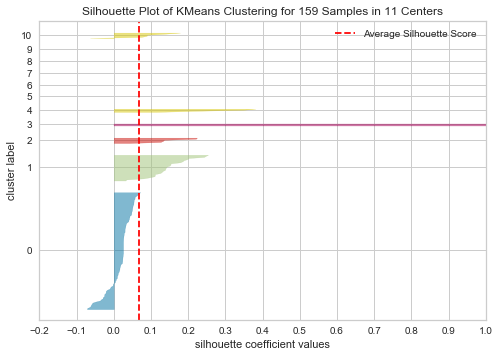

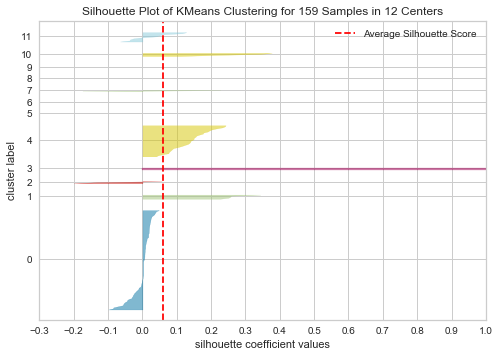

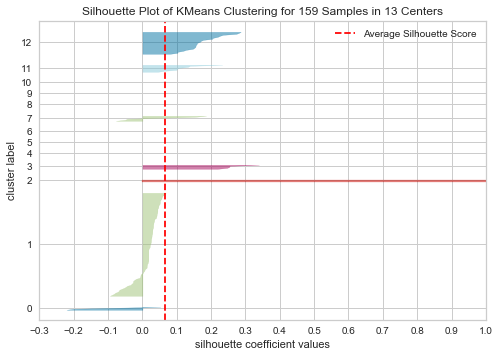

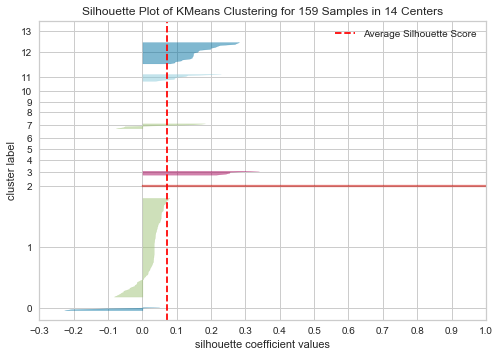

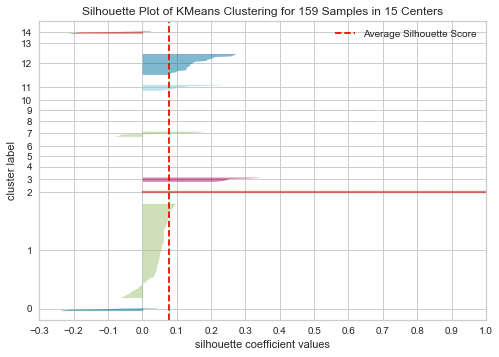

In [35]:
for k in range(2, 16) :
    model = KMeans(k, random_state=42)
    visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
    visualizer.fit(X)        # Fit the data to the visualizer
    visualizer.show()        # Finalize and render the figure

Examining the above plots, we see that the best average silhouette score is 0.22 with six clusters. The advantage of this clutering is that the neighborhoods in cluster 4 have a score of 1 which is an excellent clustering score.

As the value of k increases, will have either tiner clusters, either incorrect clusters or both.

I'm convinced now that *KMeans* algorithm is not suitable for our dataset, so let's try a more flexible one

### 7.2 DBSCAN Clutering

DBSCAN is particularly well suited for problems which require:
* Minimal domain knowledge to determine the input parameters (i.e. K in k-means and Dmin in hierarchical clustering)
* Discovery of clusters with arbitrary shapes
* Good efficiency on large databases

As is the case in most machine learning algorithms, the model’s behaviour is dictated by several parameters.
* **eps**: Two points are considered neighbors if the distance between the two points is below the threshold epsilon.
* **min_samples**: The minimum number of neighbors a given point should have in order to be classified as a core point. It’s important to note that the point itself is included in the minimum number of samples.
* **metric**: The metric to use when calculating distance between instances in a feature array (i.e. euclidean distance).

#### Find the best *Epsilon*
To find the best value for epsilon :
1. We can calculate the distance from each point to its closest neighbour using the `NearestNeighbors`. The kneighbors method returns two arrays, one which contains the distance to the closest n_neighbors points and the other which contains the index for each of those points.
2. Sort and plot results.
3. The optimal value for epsilon will be found at the point of maximum curvature.

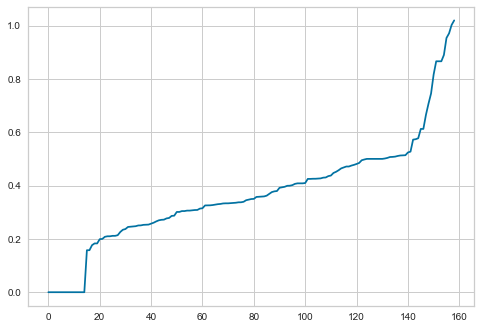

In [36]:
X = neigh_grouped.drop('Neighborhood', 1)

# calculate the distance from each point to its closest neighbour
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)

# Sort the results
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.plot(distances)

The best value for epsilon from the above plot is around *0.5*
#### Train the model
We'll train the model with our data, selecting *eps=0.5* and *min_samples=3*

In [41]:
# set number of clusters
neigh_grouped_clustering = neigh_grouped.drop('Neighborhood', 1)

# run k-means clustering
db = DBSCAN(eps=0.5, min_samples=3).fit(neigh_grouped_clustering)

neigh_venues_sorted.drop('Cluster_labels', 1, inplace=True)
# add clustering labels
neigh_venues_sorted.insert(0, 'Cluster_labels', db.labels_)

# add latitude/longitude for each neighborhood
riyadh_merged = riyadh_df.join(neigh_venues_sorted.set_index('Neighborhood'), on='Neighborhood_en')

riyadh_merged.head()

,Municipality_ar,Neighborhood_ar,Postal_code,Municipality_en,Neighborhood_en,Latitude,Longitude,Cluster_labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,بلدية العليا,حي العليا,12222,Olaya,Al Alia,24.69502,46.69004,0.0,Coffee Shop,Café,Cupcake Shop,Dessert Shop,Sporting Goods Shop,Men's Store,Clothing Store,Donut Shop,Bakery,Ice Cream Shop
1,بلدية العليا,حي الازدهار,12486,Olaya,Al-Izdihar,24.77904,46.72446,0.0,Coffee Shop,Jewelry Store,Falafel Restaurant,Bike Trail,Breakfast Spot,Health & Beauty Service,Bakery,Food Truck,Burger Joint,Chocolate Shop
2,بلدية العليا,حي المصيف,12466,Olaya,Al-Masif,24.76386,46.68849,0.0,Coffee Shop,Clothing Store,Hotel,Bakery,Sporting Goods Shop,Ice Cream Shop,Breakfast Spot,Gift Shop,Gourmet Shop,Burger Joint
3,بلدية العليا,حي التعاون,12475,Olaya,Al-Taawon,24.76724,46.69640,0.0,Coffee Shop,Donut Shop,Gift Shop,Food Truck,Garden,Gym / Fitness Center,Ethiopian Restaurant,Egyptian Restaurant,Electronics Store,Entertainment Service
4,بلدية العليا,حي الورود,12252,Olaya,Al-Worood,24.72213,46.68584,0.0,Coffee Shop,Pizza Place,Furniture / Home Store,Pharmacy,Café,Salon / Barbershop,Dessert Shop,Japanese Restaurant,Burger Joint,Food & Drink Shop


In [42]:
riyadh_merged['Cluster_labels'].value_counts()

 0.0    131
-1.0     32
 1.0      3
Name: Cluster_labels, dtype: int64

## 8. Clustering Results <a name='results'></a>
#### 8.1 Riyadh city map

In [56]:
# drop neighborhoods with no results and change the column cluster labels type
riyadh_merged.dropna(inplace=True)
riyadh_merged['Cluster_labels'] = riyadh_merged['Cluster_labels'].astype('int64')

# get Riyadh geo-coordinates
address, PARAMS = 'Riyadh, Saudi Arabia', {'apikey':api_key,'q':address}
r = requests.get(url = URL, params = PARAMS) 
data = r.json()
try :
    lat, lng = data['items'][0]['position']['lat'], data['items'][0]['position']['lng']    
except :
    lat, lng = None, None

# create map
map_clusters = folium.Map(location=[lat, lng], zoom_start=10)

# set color scheme for the clusters
kclusters = len(set(db.labels_))
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(riyadh_merged['Latitude'], riyadh_merged['Longitude'], riyadh_merged['Neighborhood_en'], riyadh_merged['Cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    if cluster == -1 : color = 'k' # plot the noise points in black
    else : color = rainbow[cluster-1]
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### 8.2 Examining clusters
The last step in this notebook is to plot for each cluster a stacked horizontal barplot with the top venues and how many times they appeared :

In [70]:
def cluster_plot(df, cluster, min_occ=None) :
    # grab the cluster members
    clus = df.loc[df['Cluster_labels'] == cluster, [venue for venue in df.columns if 'Venue' in venue]]
    
    # compute the occurence of each venue in each rank
    res = dict()
    for col in clus.columns :
        res[col] = clus[col].value_counts()
    
    # transorm the result into a dataframe
    temp = pd.DataFrame(res)
    temp = temp.fillna(0)
    
    # filter the results based on the value of the minimum occurency wanted
    temp['total'] = temp.sum(axis=1)
    temp.sort_values('total', inplace=True)
    
    if min_occ and (min_occ < max(temp.total)):
        temp = temp[temp.total >= float(min_occ)]
    else :
        print('Cluster {} don\'t have venues with an occurence greater or equal to {}!'.format(cluster, min_occ))
        print('Plotting top 10 venues instead...')
        temp = temp.iloc[:10]

    temp.drop('total', 1, inplace=True)

    # plot the results
    #plt.set_cmap('hsv')
    temp.plot.barh(stacked=True, colormap='tab10')
    plt.title('Cluster {}'.format(cluster), y=1.02)
    plt.ylabel('Venue Category')
    plt.xlabel('Venue Occurence')
    
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (20, 10),
             'axes.labelsize': 20,
             'axes.titlesize':30,
             'xtick.labelsize':'x-large',
             'ytick.labelsize':'x-large'}
    pylab.rcParams.update(params)
    plt.show()

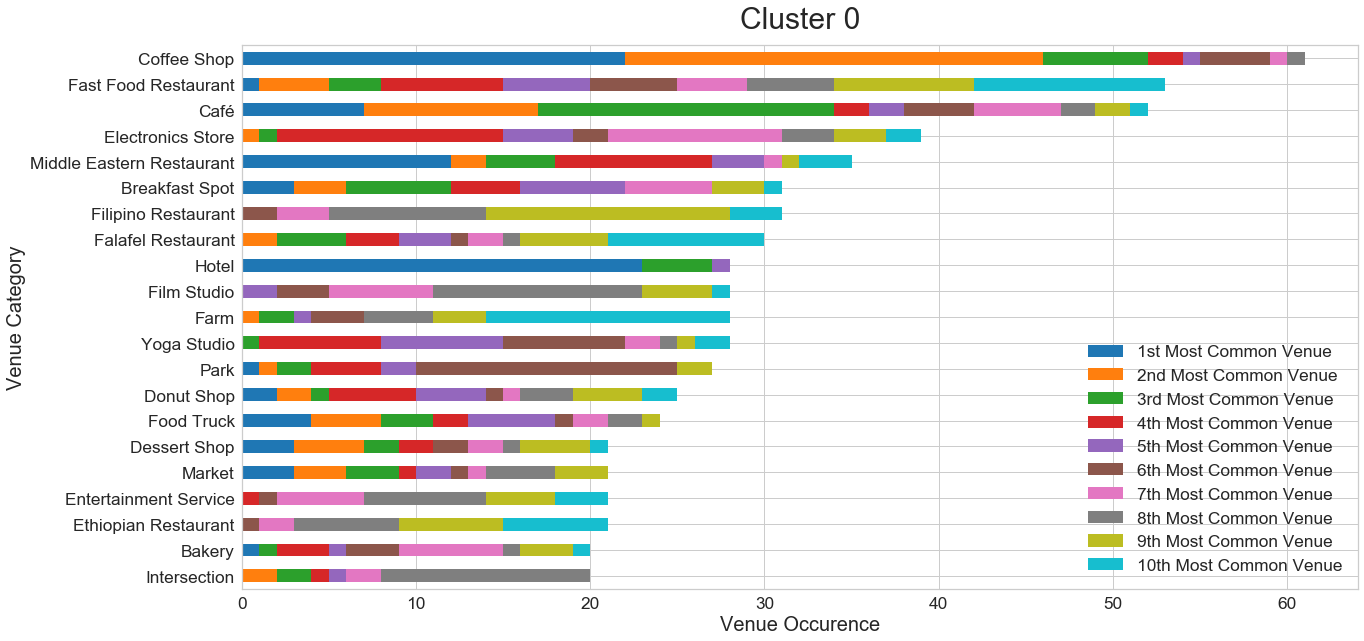

In [71]:
cluster_plot(riyadh_merged, 0, 20)

The 131 neighborhoods in this cluster (red points in the map) represent the modern city:
* Coffee shops appeared more than 60 times in the most 10 common venues, and more than 20 times as the first most common venue in cluster 0 neighborhoods.
* A lot of restaurants exist in these neighborhoods with different specialties (fast food, middle eastern, Filipino etc.)
* Hotels (22 time as first common venue) and café places (more than 50 appearances) are also so common in these neighborhoods.


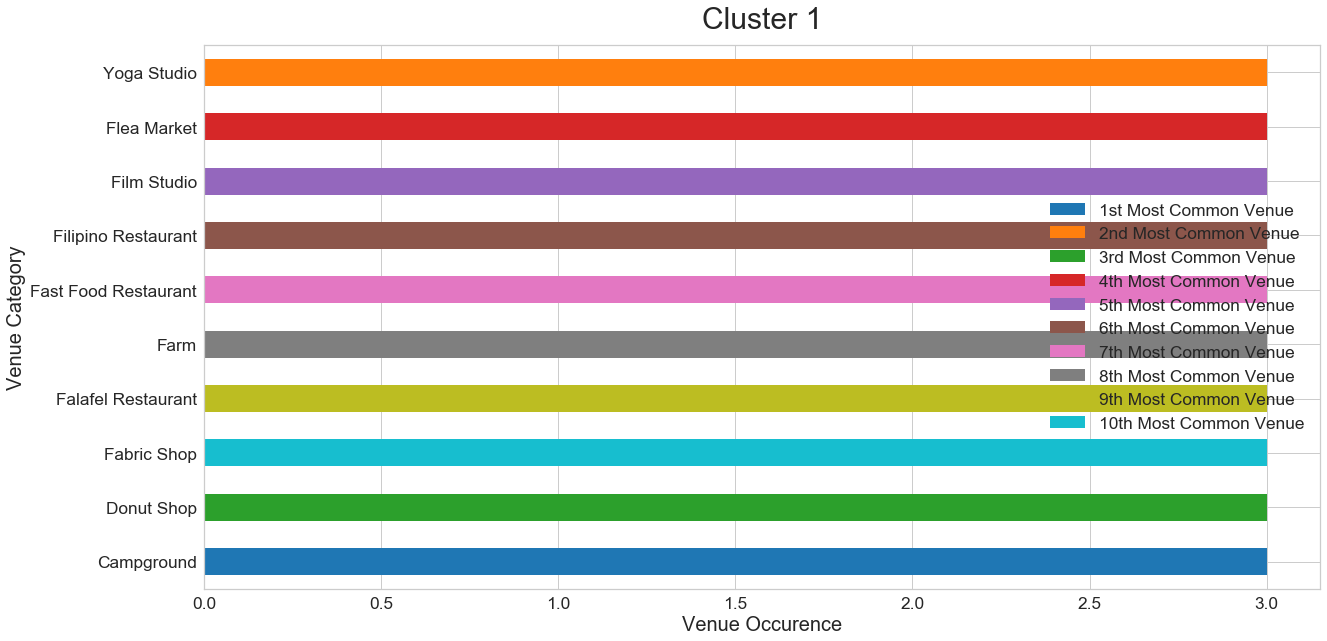

In [72]:
cluster_plot(riyadh_merged, 1, 1)

With only 3 neighborhoods in this cluster, we see:
* Campgrounds is the most common venue.
* Yoga studios is the second common venue and film studios is the fifth in all these neighborhoods.
* here exist some farms, some restaurants (with no fast food restaurants) and some shops in these neighborhoods.

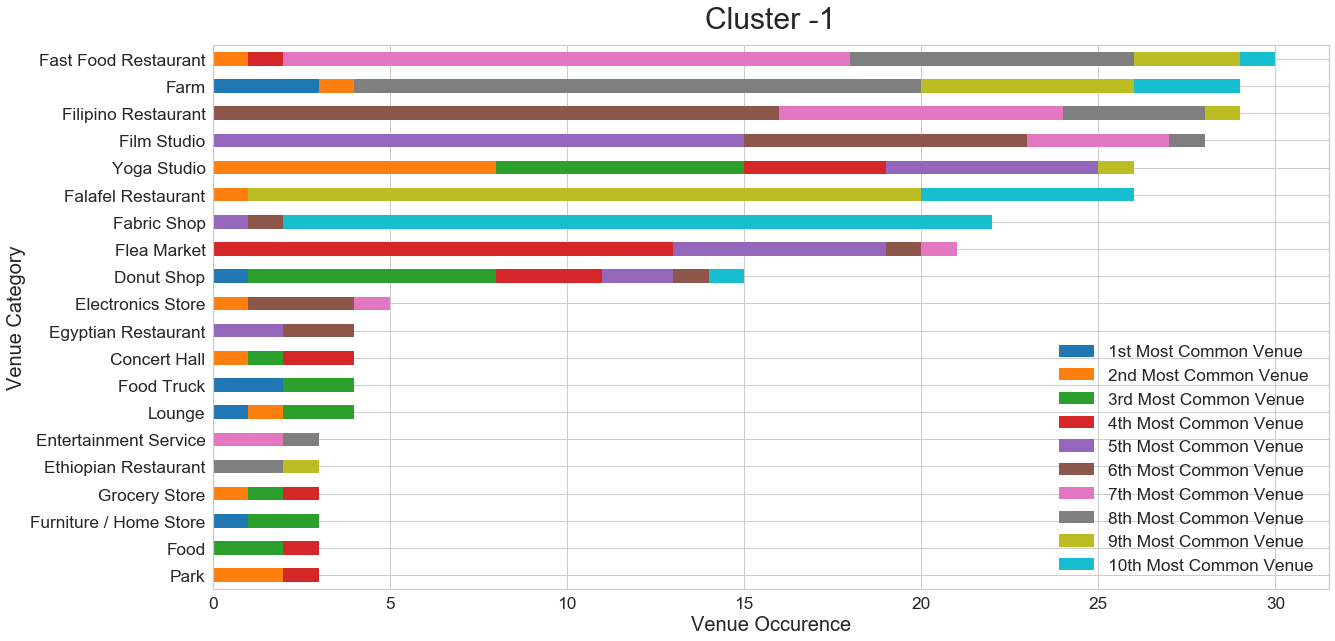

In [76]:
cluster_plot(riyadh_merged, -1, 3)

The advantage of DBSCAN clustering algorithm is its capability to recognize noise points, we observe from the above plot that neighborhoods clustered as noise have a lot of restaurants as common places but also studios, farms shops, parks, lounges, concert halls etc.

## Save the results

In [77]:
with pd.ExcelWriter('Riyadh_Neighborhoods.xlsx') as writer :
    riyadh_venues.to_excel(writer, sheet_name = 'venues')
    riyadh_merged.to_excel(writer, sheet_name= 'summary')